In [1]:
import numpy as np
import pandas as pd
import math
from msig import Motif, NullModel
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, MSTL
import matplotlib.pylab as pylab
import matplotlib.dates as mdates

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 20}
pylab.rcParams.update(params)

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
appliances_energy_prediction = fetch_ucirepo(id=374) 
  
# variable information 
print(appliances_energy_prediction.variables) 


           name     role        type demographic description  units  \
0          date  Feature        Date        None        None   None   
1    Appliances   Target     Integer        None        None     Wh   
2        lights  Feature     Integer        None        None     Wh   
3            T1  Feature  Continuous        None        None      C   
4          RH_1  Feature  Continuous        None        None      %   
5            T2  Feature  Continuous        None        None      C   
6          RH_2  Feature  Continuous        None        None      %   
7            T3  Feature  Continuous        None        None      C   
8          RH_3  Feature  Continuous        None        None      %   
9            T4  Feature  Continuous        None        None      C   
10         RH_4  Feature  Continuous        None        None      %   
11           T5  Feature  Continuous        None        None      C   
12         RH_5  Feature  Continuous        None        None      %   
13    

In [3]:
data = appliances_energy_prediction.data.original
data['timestamp'] = pd.to_datetime(data['date'], format='%Y-%m-%d%H:%M:%S')
data.drop(['date'], axis=1, inplace=True)
data.set_index('timestamp', inplace=True)
#just appliances for now
data = data.resample('10Min').last().ffill()
data = data[['Appliances']]
data.head()

,Appliances
timestamp,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60


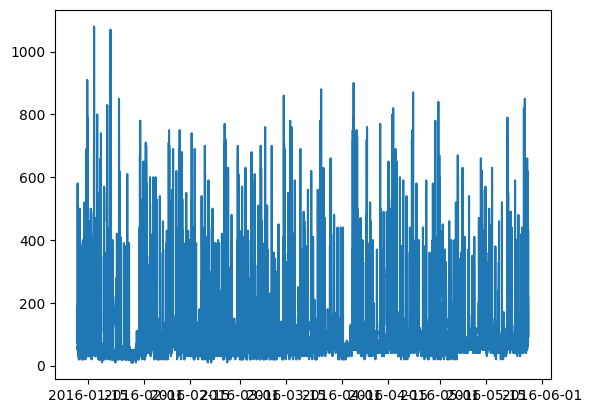

In [4]:
#Plot data.applicances
plt.plot(data['Appliances'])
plt.show()

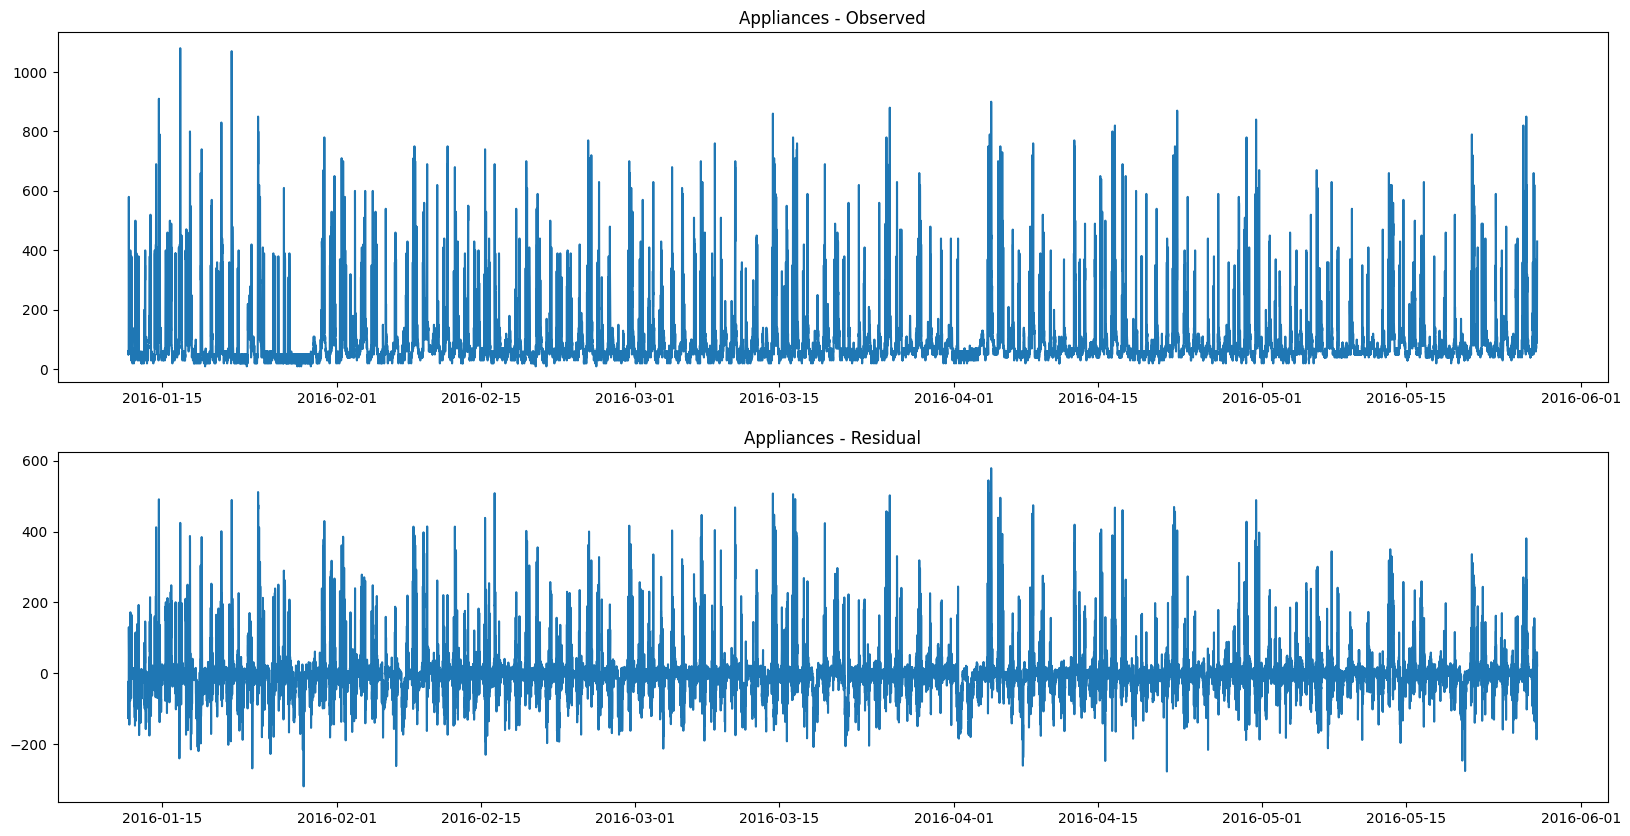

,Feature,F_T,F_S,F_R,F_seasonal_6,F_seasonal_144,F_seasonal_1008
0,Appliances,0.025,0.49,0.503,0.095,0.366,0.214


In [14]:
#resid
stats_table = pd.DataFrame()
resids = {}

#get the data for those features
for data_feature in data.columns:
    time_serie = data[data_feature].asfreq('10Min', method='ffill')
    res = MSTL(time_serie, periods=[6, 6*24, 6*24*7]).fit() #1 hour, 1 day and 1 week seasonality
    resids[data_feature] = res.resid

    var_resid = np.var(res.resid)
    var_observed = np.var(res.observed)
    trend_strength = max(0, 1 - (var_resid/np.var(res.trend+res.resid)))
    noise_strength = var_resid/var_observed

    seasonal_individial_strengths = {}
    for period in res.seasonal:
        seasonal_individial_strengths["F_"+str(period)] = max(0, 1 - (var_resid/np.var(res.seasonal[period] + res.resid)))
    seasonal_strength = max(0, 1 - (var_resid/np.var(res.seasonal.sum(axis=1) + res.resid)))


    stats_df = {"Feature": data_feature,
                "F_T": round(trend_strength, 3),
                "F_S": round(seasonal_strength, 3), "F_R": round(noise_strength, 3)}
        
    #add individual seasonal strengths to stats_df, rounded with 3 decimals
    for period in seasonal_individial_strengths:
        stats_df[period] = round(seasonal_individial_strengths[period], 3)
            
    stats_table = pd.concat([stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True)
    #plot the data
    fig, ax = plt.subplots(2,1, figsize=(20, 10))
    ax[0].plot(res.observed)
    ax[0].set_title(data_feature + " - Observed")
    ax[1].plot(res.resid)
    ax[1].set_title(data_feature + " - Residual")
    plt.show()

pd.DataFrame(resids).to_csv("../results/appliancesenergy/resids/resids.csv", index=True)
stats_table

In [7]:
#motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2 # r = np.ceil(m/2)
include = None
normalize = True
subsequence_lengths = [6, 36, 72] # 1h, 6h, 12h

In [22]:
resids = pd.read_csv("../results/appliancesenergy/resids/resids.csv", index_col=0)

for m in subsequence_lengths:
    for feature in data.columns:
        out = stumpy.stump(resids[feature], m, normalize=normalize)
        np.save('../results/appliancesenergy/mp/normalized={}_m={}_{}.npy'.format(normalize,m,feature), out, allow_pickle=True)

In [23]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))

def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time-m)/np.ceil(m/2)+1))

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]

        #minmax normalize subsequence
        epsilon = 1e-10 # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (max_values - min_values + epsilon)
        ce_norm_subsequence = multivar_subsequence_complexity(normalized_multivar_subsequence)
        norm_ce_norm_subsequence = ce_norm_subsequence/(np.sqrt(len(multivar_subsequence[0])-1)*len(dimensions))

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = max(np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)]), epsilon)
        
        unified_weights = "0.33,0.33,0.33"
        excl_zone = np.ceil(m/4)
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = w1*(1-(med_dist/max_allowed_dist)) + w2*(len(match_indices)/max_possible_matches) + w3*norm_ce_norm_subsequence

        if unified < 0:
            print(1-(med_dist/max_allowed_dist))
            print(len(match_indices)/max_possible_matches)
            print(norm_ce_norm_subsequence)

        #remove timepoints from time series in match all indices + m
        time_series_nomatches = data[dimension].copy()
        #list of indexes to remove
        indexes_to_remove = [i for index in match_indices for i in range(index, index + m)]
        #put zero in the indexes to remove
        time_series_nomatches[indexes_to_remove] = 0

        #calculate variance explained by the motif
        variance_explained = 100 * (1 - (np.var(time_series_nomatches) / np.var(data[dimension])))

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        #max_delta = max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)
        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "CE": np.around(norm_ce_norm_subsequence,3), "Score Unified": np.around(unified,3),
                        "Explained Var(%)": np.around(variance_explained,2),
                        "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.DataFrame.from_records([stats_df]) if mp_stats_table.empty else pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [25]:
k = None
min_neighbors = 2
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    for feature in data.columns:
        X = np.squeeze(resids[feature].values)
        print(X.shape)
        mp = np.load('../results/appliancesenergy/mp/normalized=True_m={}_{}.npy'.format(m,feature), allow_pickle=True)
        print(mp[:, 0].shape)
        motif_distances, motif_indices = stumpy.motifs(X, mp[:, 0], max_distance=max_distance,max_matches=max_matches,
                                                                            cutoff=cutoff, min_neighbors=min_neighbors, max_motifs=max_motifs, normalize=normalize)
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])]*len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
        print("Sig ", np.sum(table["p-value"] < 0.01))
        #hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
        sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
        table["Sig_Hochber"] = sig

        print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))
        mp_stats_table = table if mp_stats_table.empty else pd.concat([mp_stats_table, table], ignore_index=True)

        mp_stats_table.to_csv('../results/appliancesenergy/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs), index=False)

(19735,)
(19730,)
m:6, #Motifs:29
Sig  14
Sig after Hochberg: 13, critical value: 6.746345992644376e-26
(19735,)
(19700,)
m:36, #Motifs:12
Sig  12
Sig after Hochberg: 11, critical value: 2.37726278923425e-116
(19735,)
(19664,)
m:72, #Motifs:9
Sig  9
Sig after Hochberg: 8, critical value: 3.06444e-319


In [26]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)

for feature in data.columns:
    mp_stats_table = pd.read_csv('../results/appliancesenergy/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
    motif_lengths = mp_stats_table["m"].unique()
    motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
    for m in subsequence_lengths:
        table = mp_stats_table[mp_stats_table["m"] == m]
        n_motifs = table.shape[0]
        n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
        n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
        avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
        avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
        avg_probability = table["P"].mean(), table["P"].std()    
        avg_pvalue = table["p-value"].mean(), table["p-value"].std()

        stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "significant":(n_sig_motifs_001*100)/n_motifs,
                    "avg_n_matches": avg_n_matches}
        
        motif_stats_table = pd.DataFrame.from_records([stats_df]) if motif_stats_table.empty else pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
    print(motif_stats_table.to_latex(index=False))


\begin{tabular}{rrrrl}
\toprule
m & #motifs & #sig_motifs(<0.01) & significant & avg_n_matches \\
\midrule
6 & 29 & 14 & 48.275862 & (544.69, 108.215) \\
36 & 12 & 12 & 100.000000 & (233.58, 56.303) \\
72 & 9 & 9 & 100.000000 & (137.0, 45.288) \\
\bottomrule
\end{tabular}



In [27]:
def plot_motif(ts_list, features, m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/appliancesenergy/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Appliances
Motif length:  6
{'ID': 14, 'k': 1, 'Features': 0, 'm': 6, '#Matches': 554, 'Indices': '[11784, 18156, 15786, 11686, 17239, 2462, 16152, 7154, 16956, 3073, 3667, 14076, 17287, 15553, 2427, 2660, 1675, 9471, 11881, 2494, 15693, 14687, 12285, 2766, 18734, 6781, 16141, 3181, 1483, 6936, 10492, 3468, 19, 8498, 7906, 2595, 16718, 8973, 2719, 8824, 14558, 16806, 16231, 15190, 17844, 9842, 2614, 885, 10618, 16900, 12864, 13705, 8040, 9065, 5752, 5229, 10915, 16472, 19273, 3344, 9127, 13345, 6230, 6541, 19417, 568, 5733, 16736, 17054, 10533, 3725, 6453, 7401, 15712, 8770, 11436, 6345, 2203, 13935, 15443, 16327, 9805, 5353, 6632, 9310, 3434, 2030, 11978, 7765, 4081, 15428, 3526, 18920, 1608, 15478, 11570, 1440, 18099, 10012, 2363, 4057, 14549, 17143, 18874, 19264, 16751, 16086, 3292, 234, 4546, 18018, 18725, 10561, 1743, 3376, 6923, 1845, 14676, 5716, 7659, 18741, 9645, 1155, 1626, 16204, 6097, 9264, 3555, 5603, 7338, 9418, 16219, 10281, 16313, 10796, 4467, 5169, 9775, 10211, 14218, 

{'ID': 26, 'k': 1, 'Features': 0, 'm': 6, '#Matches': 622, 'Indices': '[3896, 17637, 14084, 19620, 14678, 5718, 4651, 9519, 3365, 8800, 1655, 4967, 17579, 5236, 11883, 9573, 18600, 16206, 2944, 4099, 15164, 15430, 10921, 8943, 1027, 508, 7403, 2568, 15176, 7460, 11945, 19313, 17968, 5754, 16978, 19037, 14560, 11283, 17040, 1124, 14615, 3514, 6543, 6803, 7819, 17214, 5381, 8703, 12981, 9740, 3140, 10582, 6653, 3587, 11010, 13944, 17797, 4083, 14725, 4774, 10311, 15569, 9777, 4230, 9820, 12100, 3619, 19506, 7126, 2396, 263, 5050, 7869, 12739, 11199, 10301, 5550, 887, 14506, 15459, 11755, 16780, 17021, 213, 3436, 442, 1644, 18438, 11658, 17537, 5033, 17060, 4264, 18743, 10801, 3653, 16936, 13366, 11731, 18886, 14689, 7834, 7989, 15223, 277, 6480, 2790, 11049, 6089, 11970, 5461, 1966, 15480, 17454, 9888, 9511, 17975, 9952, 16056, 19670, 359, 5470, 13968, 19324, 1474, 9647, 15602, 2341, 6569, 6142, 4519, 9858, 16347, 3909, 17919, 8600, 8852, 11956, 2285, 12228, 15555, 3681, 14591, 19421, 12

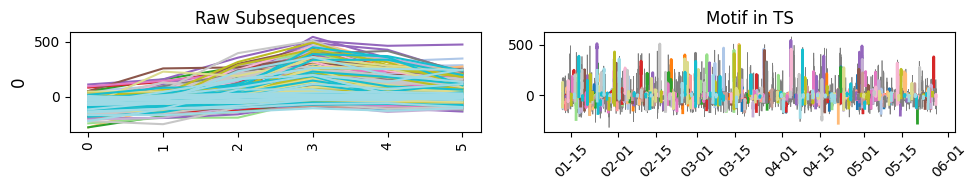

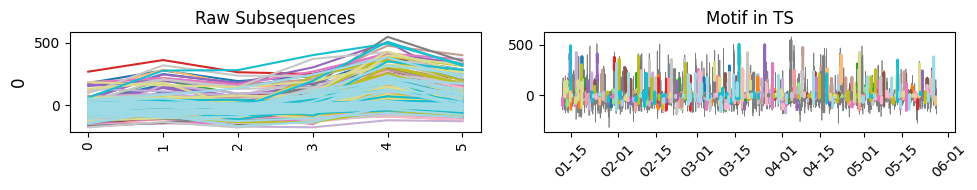

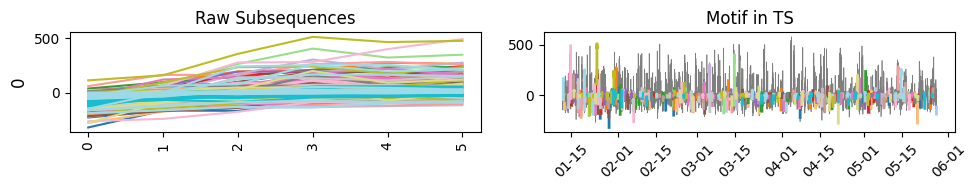

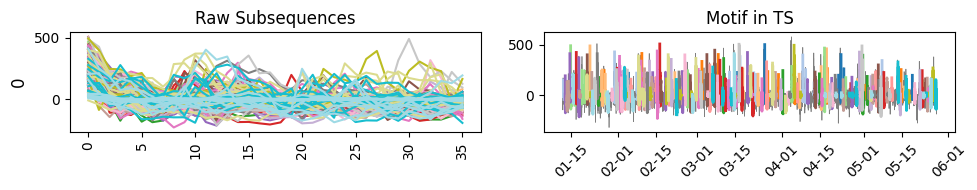

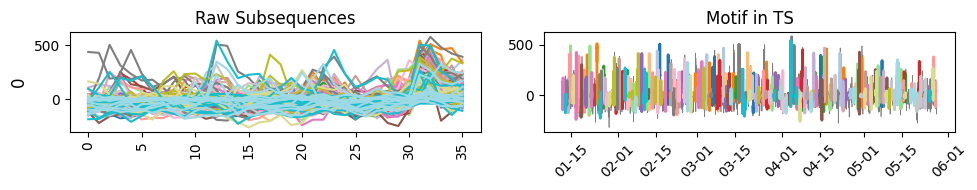

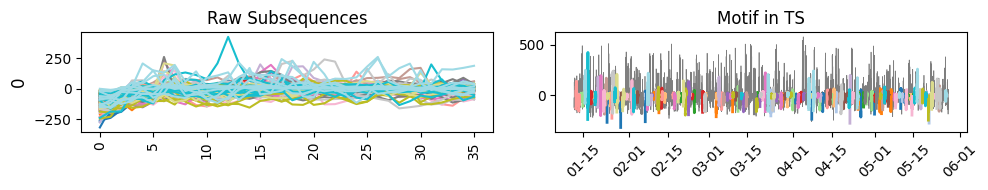

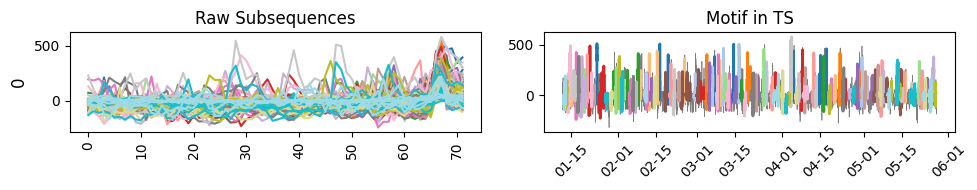

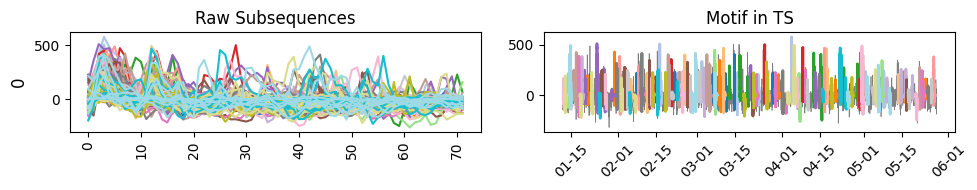

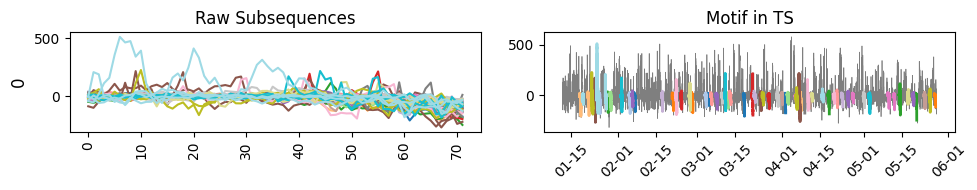

In [28]:
#plot top motif
for i, data_feature in enumerate(data.columns):
    mp_stats_table = pd.read_csv('../results/appliancesenergy/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(resids[feature].values, index=resids[feature].index)
    ts.index = pd.to_datetime(ts.index)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="p-value").head(3)
        for top_motif in top_motifs.to_dict(orient="records"): 
            print(top_motif)
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i)+"_"+str(top_motif["ID"])
            ts_list = [ts]
            plot_motif(ts_list, features, m, indices, motif_name)